In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%set_env DATA_DIR /checkpoint/dsevero/data

env: DATA_DIR=/checkpoint/dsevero/data


In [4]:
import craystack as cs
import numpy as np

from rec.definitions import Graph
from rec.models import PolyasUrnModel, SWORModel

def sample_erdos_renyi_graph(num_nodes, p, seed=0):
    np.random.seed(seed)
    adjacency_matrix = np.triu(np.random.rand(num_nodes, num_nodes) < p, k=1)
    edge_array = np.stack(np.nonzero(adjacency_matrix)).T
    return Graph(
        edge_array=edge_array,
        num_nodes=num_nodes,
        num_edges=edge_array.shape[0],
    )

num_nodes = 20
p_erdos_renyi = 1/2
graph = sample_erdos_renyi_graph(num_nodes, p_erdos_renyi)
model_pu = PolyasUrnModel(graph.num_nodes, graph.num_edges, bias=1)
model_swor = SWORModel(graph.num_nodes, graph.num_edges, max_degree=graph.num_edges)
seq_bpe, graph_bpe = model_pu.compute_bpe(graph)
print(graph_bpe)

seq_bpe, graph_bpe = model_swor.compute_bpe(graph)
print(graph_bpe)

2.7848991385588513


TypeError: only length-1 arrays can be converted to Python scalars

# NSG

In [3]:
import numpy as np
import faiss

from faiss.contrib.datasets import SyntheticDataset, DatasetSIFT1M, DatasetDeep1B
from faiss.contrib.inspect_tools import get_NSG_neighbors

ds = DatasetSIFT1M()
# ds = SyntheticDataset(d=100, nt=0, nb=10_000, nq=1)
index_nsg = faiss.index_factory(ds.d, "NSG64,Flat")
index_nsg.verbose = True
database = ds.get_database()
index_nsg.add(database)

IndexNSG::add 1000000 vectors
  Build knn graph with NNdescent S=10 R=100 L=114 niter=10
Parameters: K=64, S=10, R=100, L=114, iter=10
Iter: 0, recall@64: 0.000000
Iter: 1, recall@64: 0.002813
Iter: 2, recall@64: 0.024375
Iter: 3, recall@64: 0.119062
Iter: 4, recall@64: 0.341250
Iter: 5, recall@64: 0.579063
Iter: 6, recall@64: 0.755000
Iter: 7, recall@64: 0.857813
Iter: 8, recall@64: 0.923594
Iter: 9, recall@64: 0.959219
Added 1000000 points into the index
  Check the knn graph
  nsg building
NSG::build R=64, L=96, C=164
Degree Statistics: Max = 64, Min = 1, Avg = 22.467500
Attached nodes: 0


In [4]:
graph_friends = get_NSG_neighbors(index_nsg.nsg)
graph_friends 

array([[     2,      6,  10336, ...,     -1,     -1,     -1],
       [     3,     14,      7, ...,     -1,     -1,     -1],
       [     0,  83606, 280107, ...,     -1,     -1,     -1],
       ...,
       [575835, 567070, 218562, ...,     -1,     -1,     -1],
       [184314, 519558, 378126, ...,     -1,     -1,     -1],
       [998947, 211422, 189151, ...,     -1,     -1,     -1]], dtype=int32)

In [5]:
(graph_friends != -1).sum(axis=1)

array([32, 19, 27, ..., 29, 25, 10])

<Axes: ylabel='Frequency'>

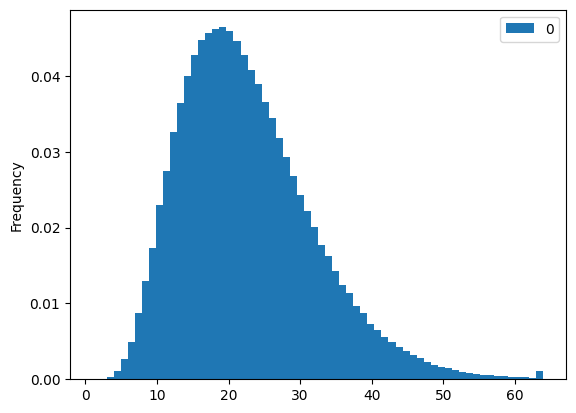

In [6]:
import pandas as pd

pd.DataFrame((graph_friends != -1).sum(axis=1)).plot.hist(bins=64, density=True)

<Axes: ylabel='Frequency'>

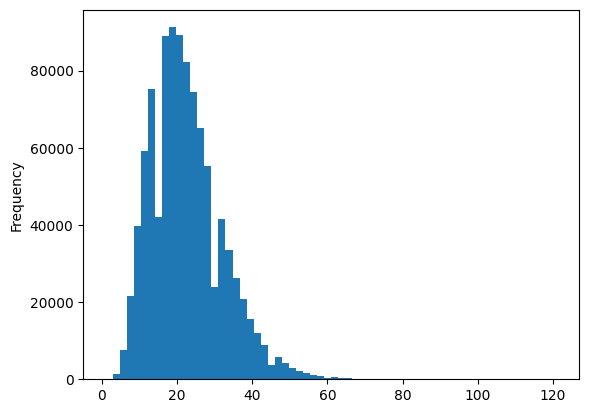

In [12]:
x = graph_friends.flatten()
pd.DataFrame(x[x != -1]).value_counts().plot.hist(bins=64, density=False)

In [7]:
from rec.datasets import load_dataset
graph_fq = load_dataset('foursquare', -1)

<Axes: ylabel='Frequency'>

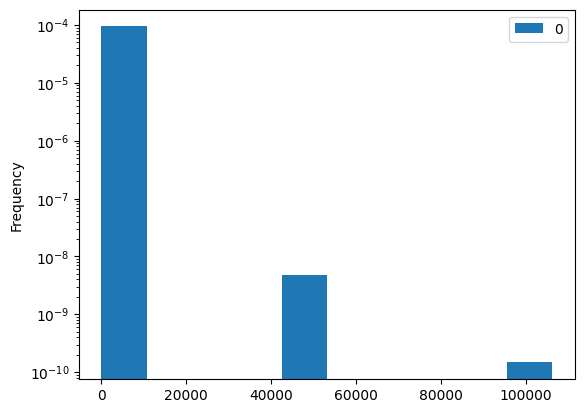

In [8]:
import pandas as pd
import numpy as np

_, num_edges_per_node = np.unique(graph_fq.edge_array.flatten(), return_counts=True)
num_edges_per_node
pd.DataFrame(num_edges_per_node[num_edges_per_node > 0]).plot.hist(density=True, logy=True)

In [9]:
def friend_to_edgelist_repr(graph_friends):
    return np.array([
        [v, w] for v, friends in enumerate(graph_friends) for w in friends if w != -1
    ])

graph_edgelist = friend_to_edgelist_repr(graph_friends)
graph_edgelist.shape

(22467500, 2)

In [10]:
graph = Graph(
    edge_array=graph_edgelist,
    num_nodes=graph_friends.shape[0],
    num_edges=len(graph_edgelist),
)
model = PolyasUrnModel(graph.num_nodes, graph.num_edges, bias=100)
seq_bpe, graph_bpe = model.compute_bpe(graph)
graph_bpe, seq_bpe

KeyboardInterrupt: 

# HNSW

In [12]:
import numpy as np
import faiss

from faiss.contrib import datasets

# make a 1000-vector dataset in 32D
ds = datasets.SyntheticDataset(32, 0, 1000, 0)
index = faiss.index_factory(ds.d, "HNSW32")
index.add(ds.get_database())
hnsw = index.hnsw
levels = faiss.vector_to_array(hnsw.levels)

def vector_to_array(v): 
    """ make a vector visible as a numpy array (without copying data)"""
    return faiss.rev_swig_ptr(v.data(), v.size())

def get_hnsw_links(hnsw, vno): 
    """ get link strcutre for vertex vno """
    
    # make arrays visible from Python
    levels = vector_to_array(hnsw.levels)
    cum_nneighbor_per_level = vector_to_array(hnsw.cum_nneighbor_per_level)
    offsets = vector_to_array(hnsw.offsets)
    neighbors = vector_to_array(hnsw.neighbors)
    
    # all neighbors of vno
    neigh_vno = neighbors[offsets[vno] : offsets[vno + 1]]
    
    # break down per level 
    nlevel = levels[vno]
    return [
        neigh_vno[cum_nneighbor_per_level[l] : cum_nneighbor_per_level[l + 1]]
        for l in range(nlevel)
    ]                

get_hnsw_links(hnsw, 592)

[array([851,  35, 347, 781, 726, 322, 889, 754, 134, 279, 366, 578, 510,
        242,  33, 712, 251, 793, 537, 572, 477, 617, 914, 101, 363, 536,
        740, 519, 842, 529, 804, 118, 814, 649,  94, 119, 755,  79, 835,
         57,  12, 349, 129,  41, 722, 890,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1],
       dtype=int32),
 array([473, 763, 344, 511,  52, 569, 877, 994, 998, 935, 133, 982, 702,
        632,  73, 136, 239, 847, 364, 770, 737, 385, 331, 944, 765,  -1,
         -1,  -1,  -1,  -1,  -1,  -1], dtype=int32),
 array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       dtype=int32)]